In [277]:
# load emnist samples and adjust data

In [278]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [279]:
import scipy.io
def load_emnist(file_path='emnist-bymerge.mat'):
    """
    Loads training and test data with ntr and nts training and test samples
    The `file_path` is the location of the `eminst-balanced.mat`.
    """    
    
    # Load the MATLAB file
    mat = scipy.io.loadmat(file_path)
    
    # Get the training data
    Xtr = mat['dataset'][0][0][0][0][0][0][:]
    ntr = Xtr.shape[0]
    ytr = mat['dataset'][0][0][0][0][0][1][:].reshape(ntr).astype(int)
    
    # Get the test data
    Xts = mat['dataset'][0][0][1][0][0][0][:]
    nts = Xts.shape[0]
    yts = mat['dataset'][0][0][1][0][0][1][:].reshape(nts).astype(int)
    
    print("%d training samples, %d test samples loaded" % (ntr, nts))

    return [Xtr, Xts, ytr, yts]

In [280]:
Xtr, Xts, ytr, yts = load_emnist()

697932 training samples, 116323 test samples loaded


In [281]:
print(Xtr.shape,Xts.shape,ytr.shape,yts.shape)

(697932, 784) (116323, 784) (697932,) (116323,)


In [282]:
Xtrd=np.reshape(Xtr,(697932,28,28),order='F')
Xtsd=np.reshape(Xts,(116323,28,28),order='F')

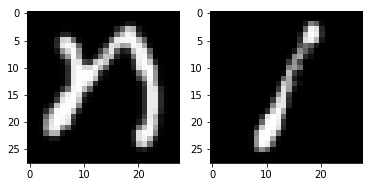

In [283]:
plt.subplot(1,2,1)
plt.imshow(Xtrd[np.random.randint(1,20000),:,:],cmap='Greys_r')
plt.subplot(1,2,2)
plt.imshow(Xtsd[np.random.randint(1,10000),:,:],cmap='Greys_r')

In [284]:
ntr = 46000
nts = 10000

# TODO: proper decide the number of samples and the ratio between dig and let

# Create sub-sampled training and test data
nsamp = Xtr.shape[0]
Iperm = np.random.permutation(nsamp)
Xtr1 = Xtrd[Iperm[:ntr],:,:]
ytr1 = ytr[Iperm[:ntr]]
nsamp = Xts.shape[0]
Iperm = np.random.permutation(nsamp)
Xts1 = Xtsd[Iperm[:nts],:,:]
yts1 = yts[Iperm[:nts]]

In [285]:
print(Xtr1.shape)
print(Xtr1[233,15:20,15:20])
print(ytr1)

(46000, 28, 28)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[12  6  4 ... 41  0 10]


In [286]:
from __future__ import print_function
# from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model #save and load models
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.backend as K

In [287]:
x_train = Xtr1.astype('float32')
x_test = Xts1.astype('float32')
x_train /= 255
x_test /= 255
x_train=x_train.reshape((ntr,28,28,1))
x_test=x_test.reshape((nts,28,28,1))
y_train=ytr1.reshape((len(ytr1),1))
y_test=yts1.reshape((len(yts1),1))
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(46000, 28, 28, 1) (10000, 28, 28, 1) (46000, 1) (10000, 1)


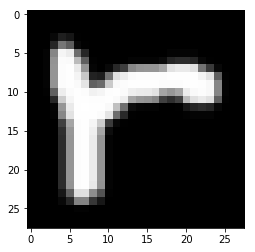

In [288]:
myxt=np.zeros((28,28))
myxt[:,:]=x_test[np.random.randint(1,10000),:,:,0]
plt.imshow(myxt,cmap='Greys_r')

In [289]:
# remove the confusing data: F
'''
num=15
for m in range(len(y_train)):
    r=np.where(y_train==num)
    x_train[r,:,:,0]=0
for m in range(len(y_test)):
    r=np.where(y_test==num)
    x_test[r,:,:,0]=0
'''

'\nnum=15\nfor m in range(len(y_train)):\n    r=np.where(y_train==num)\n    x_train[r,:,:,0]=0\nfor m in range(len(y_test)):\n    r=np.where(y_test==num)\n    x_test[r,:,:,0]=0\n'

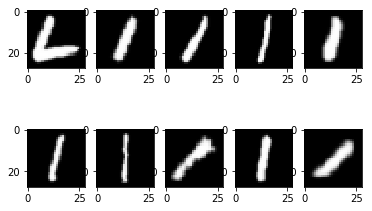

In [290]:
# find the respective letter
num=21
for m in range(10):
    r=np.where(y_train==num)[0][m]
    myxt[:,:]=x_train[r,:,:,0]
    plt.subplot(2,5,m+1)
    plt.imshow(myxt,cmap='Greys_r')

In [291]:
num_classes = 47
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('Number of classes:', y_train.shape[1])

Number of classes: 47


In [292]:
batch_size = 64
epochs = 8
lrate = 0.05
decay = lrate/epochs

In [293]:
# TODO: 36/62 channels?
K.clear_session()
model = Sequential()
model.add(Conv2D(32, (3, 3), 
                 padding='valid', 
                 input_shape=x_train.shape[1:],
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [294]:
# initiate Adam optimizer
opt = keras.optimizers.adam(lr=lrate, decay=decay)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 800)               3200      
__________

In [295]:
seed=7
k=1
c=4
# Fit the model
np.random.seed(seed)
class_weight={0:k*1.3,1:k/1.8,2:k/1.1,3:k,4:k,5:k*1.5,6:k,7:k,8:k*2,9:k*2,10:k,11:k,12:k,13:k,14:k,15:k*2,16:k,17:k,18:k,19:k,20:k,21:k*2,
              22:k,23:k,24:k*2,25:k,26:k,27:k,28:k,29:k,30:k,31:k,32:k,33:k,34:k,35:k*3,36:k,37:k*2,38:k,39:k,40:k*10,41:k*8,42:k,
              43:k,44:k*9,45:k,46:k}
hist_basic = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test),shuffle=True,
                       #class_weight='auto'
                      )

print('Done!')

Train on 46000 samples, validate on 10000 samples
Epoch 1/8
46000/46000 [==============================] - 63s 1ms/step - loss: 0.6302 - acc: 0.8027 - val_loss: 0.4271 - val_acc: 0.8616
Epoch 2/8
46000/46000 [==============================] - 63s 1ms/step - loss: 0.3775 - acc: 0.8687 - val_loss: 0.4012 - val_acc: 0.8638
Epoch 3/8
46000/46000 [==============================] - 64s 1ms/step - loss: 0.3123 - acc: 0.8860 - val_loss: 0.4087 - val_acc: 0.8629
Epoch 4/8
46000/46000 [==============================] - 63s 1ms/step - loss: 0.2725 - acc: 0.8980 - val_loss: 0.3972 - val_acc: 0.8673
Epoch 5/8
46000/46000 [==============================] - 61s 1ms/step - loss: 0.2424 - acc: 0.9065 - val_loss: 0.4307 - val_acc: 0.8664
Epoch 6/8
46000/46000 [==============================] - 63s 1ms/step - loss: 0.2147 - acc: 0.9152 - val_loss: 0.4057 - val_acc: 0.8675
Epoch 7/8
46000/46000 [==============================] - 66s 1ms/step - loss: 0.1971 - acc: 0.9217 - val_loss: 0.4199 - val_acc: 0.865

In [296]:
model.save("emnist_BatchNormalization_47_classwight_kernel2.h5")
model = load_model("emnist_BatchNormalization_47_classwight_kernel2.h5")

In [297]:
## prediction based on the model

[[1.23515804e-07 3.72122955e-08 3.33188154e-07 5.02231833e-11
  2.66159816e-07 7.74245723e-10 2.93974267e-06 8.25428259e-09
  1.30503670e-08 1.94423663e-07 3.92194522e-07 9.07756856e-08
  1.39135006e-11 5.67333132e-08 9.90347626e-09 1.37257697e-12
  2.46301897e-06 1.12099215e-05 5.48474244e-09 7.67718422e-09
  4.68045869e-07 3.39324941e-08 7.82226408e-08 5.11993903e-07
  8.78020046e-10 9.56579260e-12 2.21214600e-06 4.08123579e-09
  1.49083142e-11 3.07458663e-08 9.69479024e-01 2.14808570e-05
  3.04293744e-02 2.45321161e-07 4.07663583e-06 3.00070724e-08
  8.79328638e-07 2.48769254e-08 9.38984249e-06 4.17549190e-10
  1.87652158e-10 1.93214706e-08 3.35925979e-05 6.83860790e-08
  2.19290456e-07 5.72550236e-11 3.96266930e-09]]
30
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
u


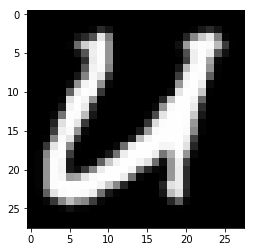

In [298]:
myn=np.random.randint(1,20000)
myxtr=np.array(x_train[myn,:,:,:])
myxtrp=np.reshape(myxtr,(28,28))
plt.imshow(myxtrp,cmap='Greys_r')
myxtr=np.reshape(myxtr,(1,28,28,1))
preds = model.predict(myxtr)
print(preds)
print(np.argmax(preds))
print(y_train[myn])
if np.argmax(y_train[myn])<10:
    ascii=48+np.argmax(y_train[myn])
else:
    ascii=87+np.argmax(y_train[myn])
print(chr(ascii))

In [299]:
yhat=model.predict(x_test)
yhatp=np.argmax(yhat,axis=1)
ytsp=np.argmax(y_test,axis=1)
acc = np.mean(yhatp == ytsp)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.862200


[[0.843 0.    0.    ... 0.    0.    0.   ]
 [0.    0.739 0.002 ... 0.    0.    0.   ]
 [0.    0.    0.957 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.2   0.    0.   ]
 [0.    0.014 0.    ... 0.    0.829 0.014]
 [0.    0.    0.    ... 0.    0.    0.895]]


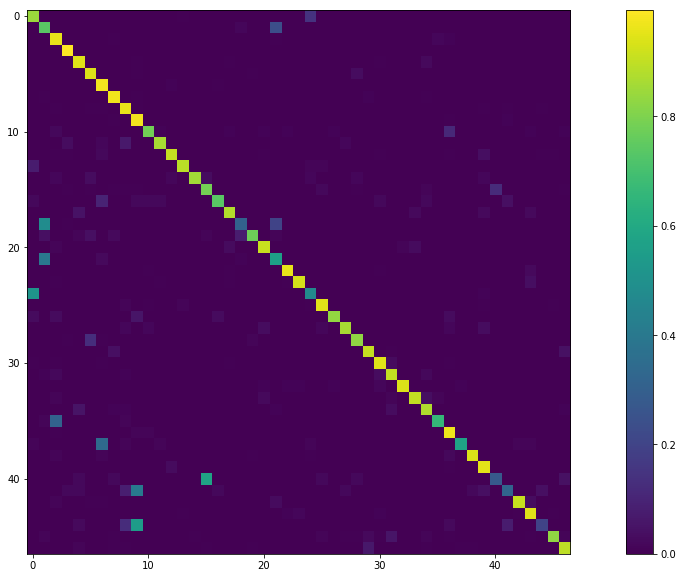

In [300]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

C = confusion_matrix(ytsp,yhatp)

# Normalize the confusion matrix
#Csum = np.sum(C,1)
#C = C / Csum[None,:]
C = normalize(C, norm='l1', axis=1)

# Print the confusion matrix
print(np.array_str(C, precision=3, suppress_small=True))
plt.figure(figsize=(20, 10))
plt.imshow(C, interpolation='none')
plt.colorbar()

In [301]:
Cd=C.diagonal()
print(Cd)
print(np.where(Cd<0.8))

[0.84325397 0.73854962 0.95687885 0.99441341 0.94639175 0.94305239
 0.97797357 0.97194389 0.96082474 0.975      0.78409091 0.86440678
 0.90769231 0.89230769 0.85483871 0.78787879 0.74       0.87804878
 0.31279621 0.77333333 0.90909091 0.56610169 0.95679012 0.93023256
 0.47150259 0.95092025 0.83333333 0.86440678 0.82857143 0.90849673
 0.94977169 0.90322581 0.94117647 0.9047619  0.875      0.66233766
 0.96969697 0.57142857 0.93835616 0.95396419 0.27906977 0.31914894
 0.9109589  0.94565217 0.2        0.82938389 0.89495798]
(array([ 1, 10, 15, 16, 18, 19, 21, 24, 35, 37, 40, 41, 44]),)


In [ ]:
# use a loop to find the best parameter

In [303]:
history=[]
nodes=np.array([384,512,640])
nconvs=np.array([16,32,48])
for i,nc in enumerate(nconvs):
    for j,node in enumerate(nodes):
        K.clear_session()
        model = Sequential()
        model.add(Conv2D(nc, (3, 3), 
                         padding='valid', 
                         input_shape=x_train.shape[1:],
                         activation='relu'))
        #model.add(BatchNormalization())
        #model.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))   #+0.01
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Conv2D(nc, (3, 3), padding='valid', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        #model.add(Conv2D(28, (3, 3), padding='valid', activation='relu'))   #+0.00
        #model.add(BatchNormalization())

        model.add(Flatten())
        model.add(BatchNormalization())
        model.add(Dense(node, activation='relu'))
        model.add(BatchNormalization())
        #model.add(Dense(62, activation='relu'))   #+0.01
        #model.add(BatchNormalization())
        opt = keras.optimizers.adam(lr=lrate, decay=decay)
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
        print('nc={},node={}'.format(nc,node))
        hist_basic = model.fit(x_train, y_train,batch_size=batch_size,
                               epochs=epochs,validation_data=(x_test, y_test),shuffle=True)
        history.append(hist_basic)
        

nc=16,node=384
Train on 46000 samples, validate on 10000 samples
Epoch 1/8
46000/46000 [==============================] - 29s 640us/step - loss: 0.7548 - acc: 0.7863 - val_loss: 0.4637 - val_acc: 0.8417
Epoch 2/8
46000/46000 [==============================] - 28s 614us/step - loss: 0.3944 - acc: 0.8632 - val_loss: 0.3924 - val_acc: 0.8644
Epoch 3/8
46000/46000 [==============================] - 28s 606us/step - loss: 0.3256 - acc: 0.8814 - val_loss: 0.3784 - val_acc: 0.8740
Epoch 4/8
46000/46000 [==============================] - 29s 625us/step - loss: 0.2899 - acc: 0.8925 - val_loss: 0.3865 - val_acc: 0.8741
Epoch 5/8
46000/46000 [==============================] - 28s 608us/step - loss: 0.2595 - acc: 0.9013 - val_loss: 0.3888 - val_acc: 0.8737
Epoch 6/8
46000/46000 [==============================] - 28s 611us/step - loss: 0.2366 - acc: 0.9104 - val_loss: 0.3883 - val_acc: 0.8748
Epoch 7/8
46000/46000 [==============================] - 28s 612us/step - loss: 0.2188 - acc: 0.9144 - val_

46000/46000 [==============================] - 97s 2ms/step - loss: 0.8842 - acc: 0.7788 - val_loss: 0.4717 - val_acc: 0.8389
Epoch 2/8
46000/46000 [==============================] - 92s 2ms/step - loss: 0.3909 - acc: 0.8625 - val_loss: 0.3847 - val_acc: 0.8690
Epoch 3/8
46000/46000 [==============================] - 92s 2ms/step - loss: 0.3213 - acc: 0.8834 - val_loss: 0.3819 - val_acc: 0.8684
Epoch 4/8
46000/46000 [==============================] - 92s 2ms/step - loss: 0.2832 - acc: 0.8954 - val_loss: 0.3800 - val_acc: 0.8759
Epoch 5/8
46000/46000 [==============================] - 92s 2ms/step - loss: 0.2515 - acc: 0.9045 - val_loss: 0.3748 - val_acc: 0.8773
Epoch 6/8
46000/46000 [==============================] - 93s 2ms/step - loss: 0.2298 - acc: 0.9128 - val_loss: 0.3798 - val_acc: 0.8769
Epoch 7/8
46000/46000 [==============================] - 92s 2ms/step - loss: 0.2072 - acc: 0.9190 - val_loss: 0.3862 - val_acc: 0.8799
Epoch 8/8
46000/46000 [==============================] - 9

In [304]:
h=np.zeros((9,1))
for n in range(9):
    h[n]=np.max(history[n].history['val_acc'])
h1=h.reshape((len(nconvs),len(nodes)))
print(h1)
print(h1.shape)
c=0
for i,nc in enumerate(nconvs):
    for j,node in enumerate(nodes):
        if h1[i,j]>c:
            c=h1[i,j]
            convmax=nc
            nodemax=node
print('the best nconvs is {},the best nnode is {}'.format(convmax,nodemax))
print('the maximum val_accuracy is {}'.format(np.max(h1)))

[[0.8748 0.8751 0.8799]
 [0.8825 0.8765 0.8754]
 [0.8811 0.8799 0.8785]]
(3, 3)
the best nconvs is 32,the best nnode is 384
the maximum val_accuracy is 0.8825


In [ ]:
# go further from above to find better nconvs and n node

In [305]:
history=[]
nodes=np.array([320,384,448])
nconvs=np.array([24,32,40])
for i,nc in enumerate(nconvs):
    for j,node in enumerate(nodes):
        K.clear_session()
        model = Sequential()
        model.add(Conv2D(nc, (3, 3), 
                         padding='valid', 
                         input_shape=x_train.shape[1:],
                         activation='relu'))
        #model.add(BatchNormalization())
        #model.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))   #+0.01
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Conv2D(nc, (3, 3), padding='valid', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        #model.add(Conv2D(28, (3, 3), padding='valid', activation='relu'))   #+0.00
        #model.add(BatchNormalization())

        model.add(Flatten())
        model.add(BatchNormalization())
        model.add(Dense(node, activation='relu'))
        model.add(BatchNormalization())
        #model.add(Dense(62, activation='relu'))   #+0.01
        #model.add(BatchNormalization())
        opt = keras.optimizers.adam(lr=lrate, decay=decay)
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
        print('nc={},node={}'.format(nc,node))
        hist_basic = model.fit(x_train, y_train,batch_size=batch_size,
                               epochs=epochs,validation_data=(x_test, y_test),shuffle=True)
        history.append(hist_basic)
        

nc=24,node=320
Train on 46000 samples, validate on 10000 samples
Epoch 1/8
46000/46000 [==============================] - 48s 1ms/step - loss: 0.6819 - acc: 0.7966 - val_loss: 0.4265 - val_acc: 0.8564
Epoch 2/8
46000/46000 [==============================] - 45s 978us/step - loss: 0.3733 - acc: 0.8688 - val_loss: 0.3767 - val_acc: 0.8716
Epoch 3/8
46000/46000 [==============================] - 45s 981us/step - loss: 0.3129 - acc: 0.8860 - val_loss: 0.3692 - val_acc: 0.8732
Epoch 4/8
46000/46000 [==============================] - 46s 996us/step - loss: 0.2722 - acc: 0.8973 - val_loss: 0.3689 - val_acc: 0.8759
Epoch 5/8
46000/46000 [==============================] - 47s 1ms/step - loss: 0.2435 - acc: 0.9066 - val_loss: 0.3786 - val_acc: 0.8713
Epoch 6/8
46000/46000 [==============================] - 47s 1ms/step - loss: 0.2218 - acc: 0.9136 - val_loss: 0.3775 - val_acc: 0.8767
Epoch 7/8
46000/46000 [==============================] - 47s 1ms/step - loss: 0.2036 - acc: 0.9215 - val_loss: 0.

In [306]:
h=np.zeros((9,1))
for n in range(9):
    h[n]=np.max(history[n].history['val_acc'])
h1=h.reshape((len(nconvs),len(nodes)))
print(h1)
print(h1.shape)
c=0
for i,nc in enumerate(nconvs):
    for j,node in enumerate(nodes):
        if h1[i,j]>c:
            c=h1[i,j]
            convmax=nc
            nodemax=node
print('the best nconvs is {},the best nnode is {}'.format(convmax,nodemax))
print('the maximum val_accuracy is {}'.format(np.max(h1)))

[[0.8789 0.8795 0.8801]
 [0.8808 0.8794 0.879 ]
 [0.8789 0.8824 0.8777]]
(3, 3)
the best nconvs is 40,the best nnode is 384
the maximum val_accuracy is 0.8824


In [ ]:
# find the best parameters in adam optimizer

In [307]:
history1=[]
nlrate=np.array([0.5,0.1,0.05,0.01,0.005])
for i,lrate in enumerate(nlrate):
    K.clear_session()
    model = Sequential()
    model.add(Conv2D(convmax, (3, 3), 
                     padding='valid', 
                     input_shape=x_train.shape[1:],
                     activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Conv2D(32, (3, 3), padding='valid', activation='relu'))   #+0.01
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(convmax, (3, 3), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Conv2D(28, (3, 3), padding='valid', activation='relu'))   #+0.00
    #model.add(BatchNormalization())

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(nodemax, activation='relu'))
    model.add(BatchNormalization())
    #model.add(Dense(62, activation='relu'))   #+0.01
    #model.add(BatchNormalization())
    decay = lrate/epochs
    opt = keras.optimizers.adam(lr=lrate, decay=decay)
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    print('nlrate={}'.format(lrate))
    hist_basic = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,
                           validation_data=(x_test, y_test),shuffle=True)
    history1.append(hist_basic)
        

nlrate=0.5
Train on 46000 samples, validate on 10000 samples
Epoch 1/8
46000/46000 [==============================] - 71s 2ms/step - loss: 15.3239 - acc: 0.0481 - val_loss: 15.3364 - val_acc: 0.0485
Epoch 2/8
46000/46000 [==============================] - 70s 2ms/step - loss: 15.3378 - acc: 0.0484 - val_loss: 15.3380 - val_acc: 0.0484
Epoch 3/8
46000/46000 [==============================] - 70s 2ms/step - loss: 15.3378 - acc: 0.0484 - val_loss: 15.3364 - val_acc: 0.0485
Epoch 4/8
46000/46000 [==============================] - 69s 2ms/step - loss: 15.3378 - acc: 0.0484 - val_loss: 15.3380 - val_acc: 0.0484
Epoch 5/8
46000/46000 [==============================] - 69s 2ms/step - loss: 15.3378 - acc: 0.0484 - val_loss: 15.3373 - val_acc: 0.0484
Epoch 6/8
46000/46000 [==============================] - 73s 2ms/step - loss: 15.3378 - acc: 0.0484 - val_loss: 15.3380 - val_acc: 0.0484
Epoch 7/8
46000/46000 [==============================] - 75s 2ms/step - loss: 15.3378 - acc: 0.0484 - val_loss:

In [308]:
hh=np.zeros((5,1))
for n in range(5):
    hh[n]=np.max(history1[n].history['val_acc'])
print(hh)
c=0
for i,lrate in enumerate(nlrate):
    if hh[i]>c:
        c=hh[i]
        lratemax=lrate
print('the best nlrate is {}'.format(lratemax))
print('the maximum val_accuracy is {}'.format(np.max(hh)))

[[0.0485]
 [0.8681]
 [0.8778]
 [0.8789]
 [0.8832]]
the best nlrate is 0.005
the maximum val_accuracy is 0.8832
